<a href="https://colab.research.google.com/github/B4ben-69/tensorFlow_edging/blob/main/Process_Input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emd

(46871, 10) (46871, 9) (46871, 1)


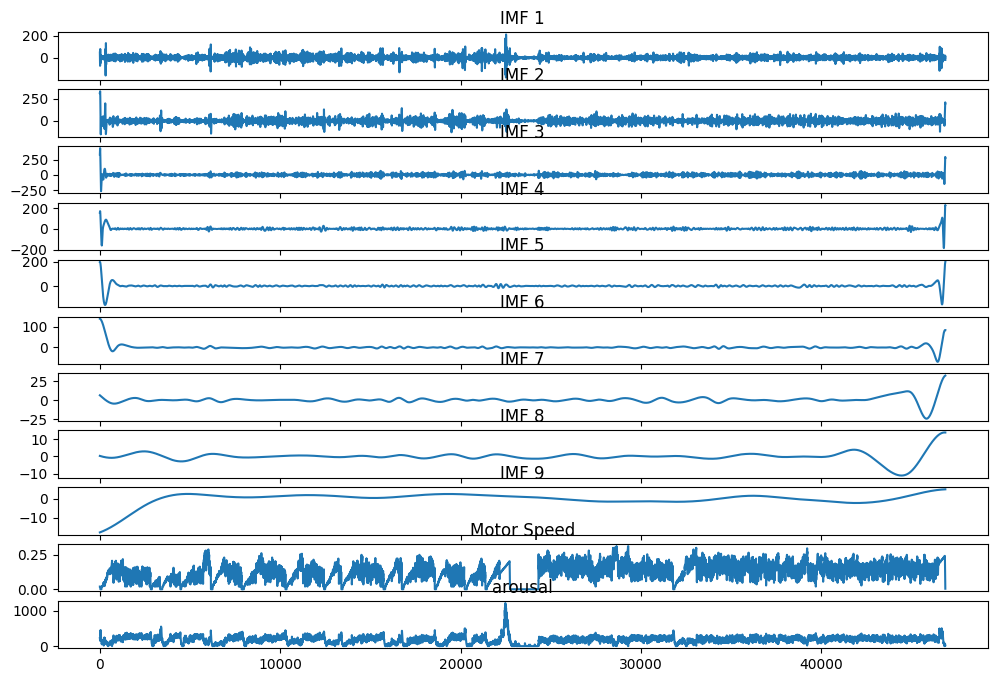

In [18]:
import emd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import OneHotEncoder

# Load data from JSON, ignoring lines with "wifiStatus"
with open('/content/drive/MyDrive/Colab Notebooks/stream_output_20240902_085854.txt', 'r') as f:
  data = []
  for line in f:
    try:
      item = json.loads(line)
      if 'pressure' in item:  # Assuming your relevant data has "pressure" key
        data.append(item)
    except json.JSONDecodeError:
      pass  # Ignore lines that are not valid JSON

# Now you have a list of dictionaries with relevant data
# Extract pressure values
pressure_values = [item['pressure'] for item in data]
# Extract pressure values
pressure_values = [item['pressure'] for item in data]

window_size = 100  # Adjust as needed
moving_avg = np.convolve(pressure_values, np.ones(window_size), 'same') / window_size
pressure_values_normalized = pressure_values - moving_avg

# Create an EMD object and extract IMFs
imf = emd.sift.sift(np.array(pressure_values_normalized))
imfs = imf[:, 1:]

# Extract other features from JSON data
# Normalize motor values to the range [0, 1]
motor_values = np.array([item['motor'] for item in data]) / 255.0

runMode_values = np.array([item['runMode'] for item in data])
# One-hot encode runMode
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for numpy array
runMode_encoded = encoder.fit_transform(runMode_values.reshape(-1, 1))
arousal = np.array([item['arousal'] for item in data])

# Convert string booleans to integers
permitOrgasm_values = np.array([1 if item['permitOrgasm'] == 'true' else 0 for item in data])

# Create a NumPy array with IMFs and other features
# Ensure all feature arrays have the same length
min_length = min(len(imfs), len(motor_values), len(runMode_values), len(permitOrgasm_values))
#dataset = np.hstack((imfs[:min_length],
#                      motor_values[:min_length].reshape(-1, 1),
#                      runMode_encoded[:min_length],
#                      permitOrgasm_values[:min_length].reshape(-1, 1)))
dataset = np.hstack((imfs,
                      motor_values.reshape(-1, 1),
                      ))


# Print the shape of the dataset
print(dataset.shape, imfs.shape, motor_values.reshape(-1, 1).shape)

# Plot the IMFs and motor speed
num_imfs = imfs.shape[1]
fig, axes = plt.subplots(num_imfs + 2, 1, figsize=(12, 8))

# Plot IMFs
for i in range(num_imfs):
  axes[i].plot(imfs[:, i])
  axes[i].set_title(f"IMF {i+1}")

# Plot motor speed in the last subplot
axes[num_imfs].plot(motor_values)
axes[num_imfs].set_title('Motor Speed')

# Plot arousal in the last subplot
axes[num_imfs+1].plot(arousal)
axes[num_imfs+1].set_title('arousal')
#plt.tight_layout()
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'dataset' is your NumPy array containing IMFs and motor values
# ... (your existing code)

# Define the possible actions
actions = ['Stop', 'reduce -2', 'reduce -1', 'nochange', 'augment +1', 'augment +2']

# Generate example output labels (replace with your actual labels)
# Ensure the length matches your dataset
output_labels = np.random.choice(actions, size=len(dataset))

# Encode the output labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(output_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    dataset, encoded_labels, test_size=0.2, random_state=42
)

# Create a neural network model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(dataset.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Make predictions
predictions = model.predict(X_test)
predicted_actions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# ... (rest of your code)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1660 - loss: 2.0942 - val_accuracy: 0.1619 - val_loss: 1.8267
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1703 - loss: 1.8073 - val_accuracy: 0.1655 - val_loss: 1.7952
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1708 - loss: 1.7925 - val_accuracy: 0.1653 - val_loss: 1.7928
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1689 - loss: 1.7915 - val_accuracy: 0.1605 - val_loss: 1.7943
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1684 - loss: 1.7915 - val_accuracy: 0.1618 - val_loss: 1.7929
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1683 - loss: 1.7918 - val_accuracy: 0.1663 - val_loss: 1.7924
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1694 - loss: 1.7915 - val_accuracy: 0.1635 - val_loss: 1.7938
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1705 - loss: 1.7920 - 

In [ ]:
dataset[:100]